# Decision Tree Model
## Model 2

# Imports 

In [74]:
# Imports
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, validation_curve, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

In [75]:
# Import change_summary
changelog = pd.read_csv('../Changelogs/change_summary.csv').to_dict(orient='records')

# Change summary intialization and check
change_summary = pd.DataFrame(changelog)
pd.set_option('display.max_colwidth', None)
display(change_summary)  

,column,change,rationale
0,age,Removed 3 row(s) where age > 125,Oldest verified human lived to be 122; values above 125 are likely errors or outliers.
1,loan_status,Dropped loan_status column,Target variable for classification; not needed in cleaned dataset.
2,person_income,"Capped person_income at $3,000,000 and applied log1p transformation",Handled extreme right skew and outliers in income distribution; log1p applied to normalize values and removed person_income for modeling.
3,loan_amnt,Applied log1p transformation to loan_amount,Handled extreme right skew and outliers in loan amount distribution; log1p applied to normalize values.
4,person_emp_exp,Removed 5 row(s) where person_emp_exp > 70,Unrealistic employment experience; values above 70 years are likely errors or outliers.
5,numerical_columns,Scaled numerical columns using MinMaxScaler,"Normalized numerical features to a range of [0, 1] for better model performance."
6,"['person_gender', 'person_education', 'person_home_ownership', 'loan_intent', 'previous_loan_defaults_on_file']","Removed 117 row(s) containing ""unknown"" values","""unknown"" adds noise and uncertainty in modeling categorical variables"
7,"['person_gender', 'person_education', 'person_home_ownership', 'loan_intent', 'previous_loan_defaults_on_file']",Applied one-hot encoding (drop_first=True),Converted categorical variables into binary indicators for model compatibility.
8,loan_status,Readded loan_status column,Target variable for classification; readded after cleaning and preprocessing.


# Data Prep

In [76]:
# Load cleaned data from CSV
df = pd.read_csv("../Data/cleaned_loan_data.csv")
df.head()

,person_age,person_emp_exp,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,log_income,log_loan_amt,person_gender_male,person_education_Bachelor,...,person_education_Master,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,previous_loan_defaults_on_file_Yes,loan_status
0,0.031250,0.000000,0.727023,0.742424,0.035714,0.434010,0.383734,1.000000,0,0,...,1,0,1,0,0,0,1,0,0,1
1,0.015625,0.000000,0.392318,0.121212,0.000000,0.289340,0.074890,0.162992,0,0,...,0,1,0,1,0,0,0,0,1,0
2,0.078125,0.048387,0.510974,0.666667,0.035714,0.621827,0.077095,0.564245,0,0,...,0,0,0,0,0,1,0,0,0,1
3,0.046875,0.000000,0.672840,0.666667,0.000000,0.723350,0.401728,1.000000,0,1,...,0,0,1,0,0,1,0,0,0,1
4,0.062500,0.016129,0.606996,0.803030,0.071429,0.497462,0.369016,1.000000,1,0,...,1,0,1,0,0,1,0,0,0,1


In [77]:
# Split the data into features and target variable
X = df.drop(columns=['loan_status'])
y = df['loan_status']

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True, stratify=y)
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")

X_train: (31412, 21)
X_test: (13463, 21)


# Models


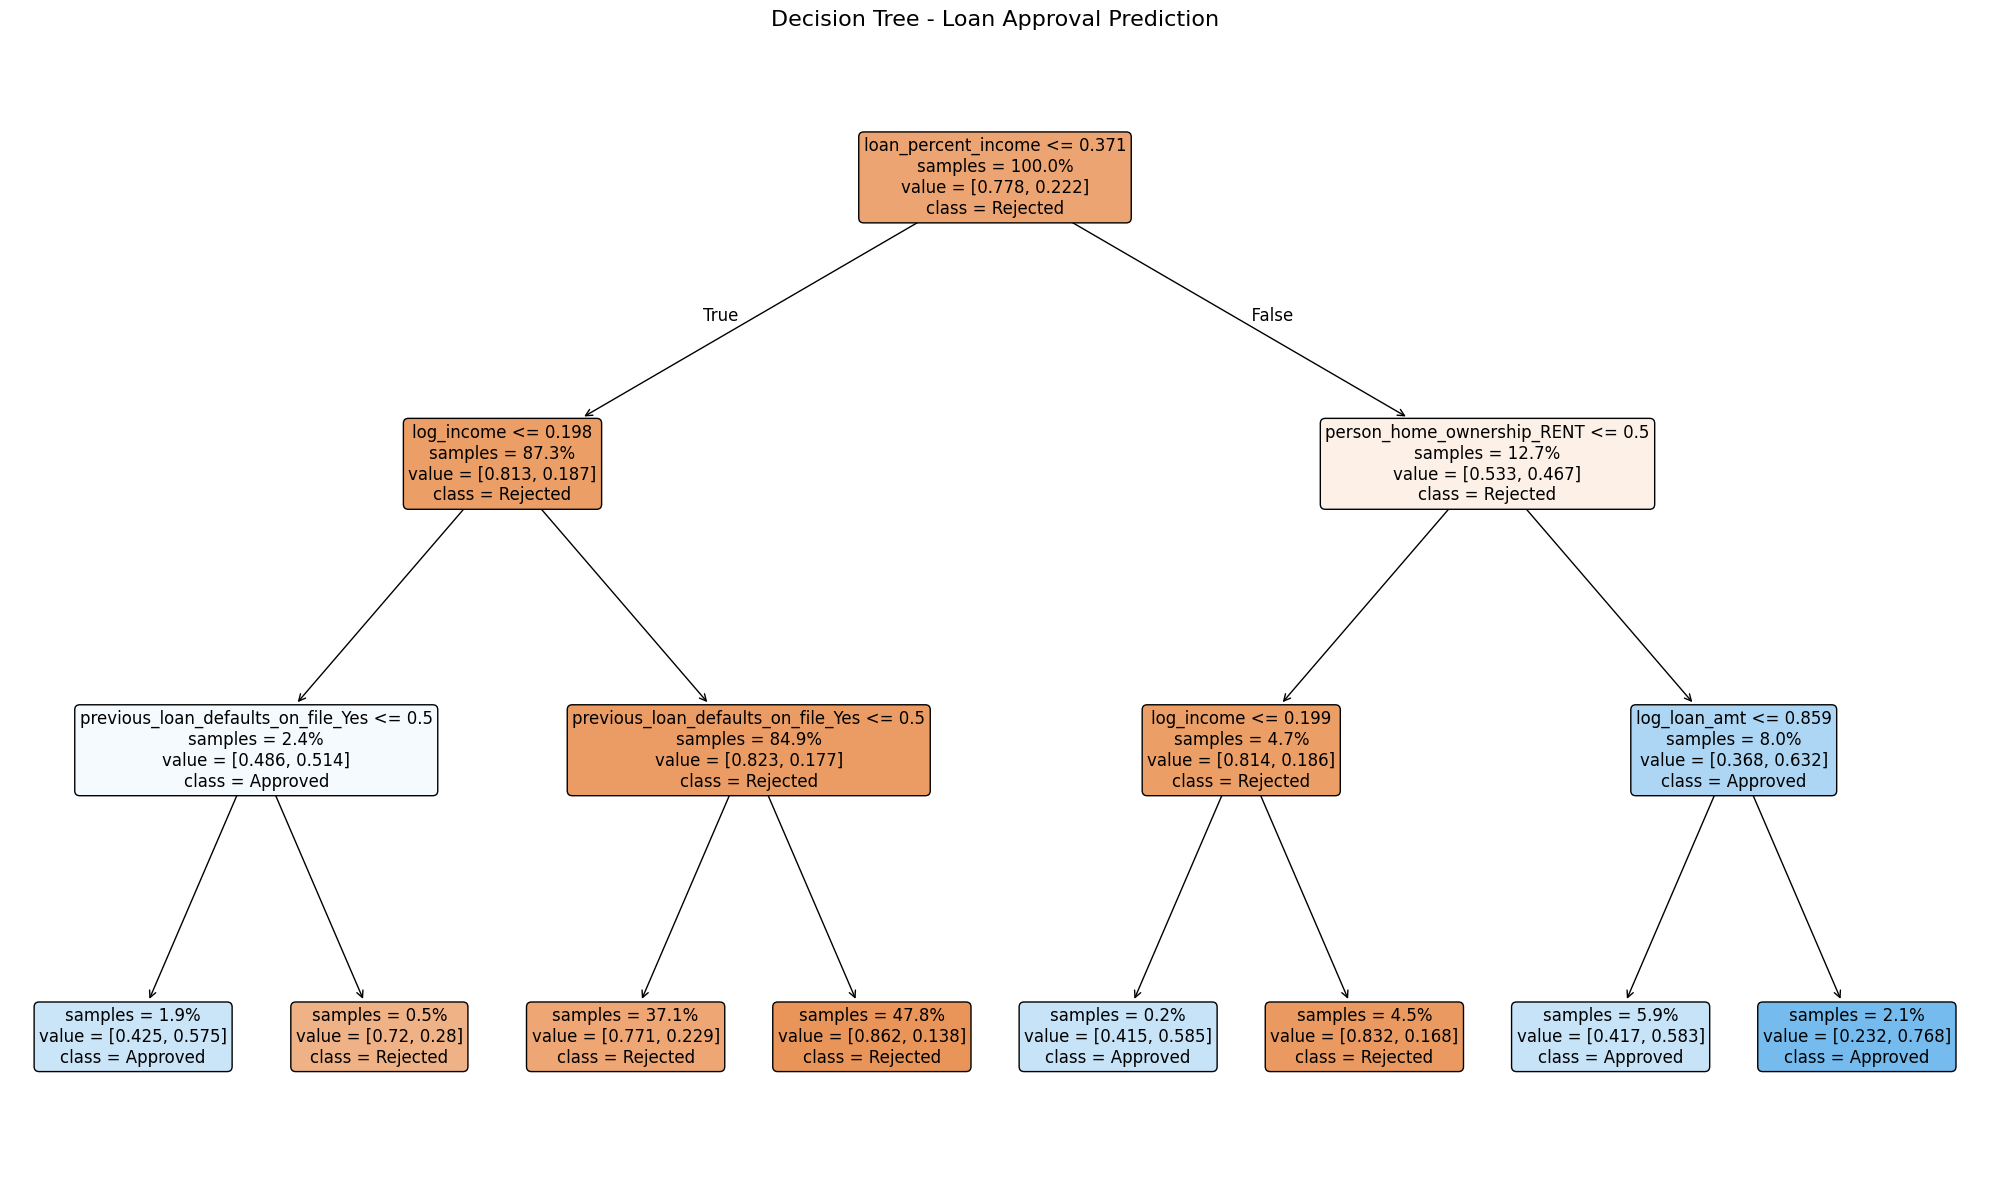

In [79]:
# Decision Tree
dt_model = DecisionTreeClassifier(max_depth=3,random_state=42)
dt_model.fit(X_train, y_train)


# Visualize the Decision Tree
plt.figure(figsize=(20, 12))  
plot_tree(dt_model,
          filled=True,
          rounded=True,
          feature_names=X_train.columns,
          class_names=['Rejected', 'Approved'],
          fontsize=12,
          impurity=False,       
          proportion=True)      
plt.title("Decision Tree - Loan Approval Prediction", fontsize=16)
plt.tight_layout()
plt.show()

In [80]:
# Applying SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Combine into new balanced DataFrame
df_balanced = pd.concat(
    [pd.DataFrame(X_resampled, columns=X.columns),
     pd.Series(y_resampled, name='loan_status')],
    axis=1
)


# SMOTE changelog entry
changelog.append({
    'column': 'subscribe_to_term_deposit',
    'change': f'Resampled with SMOTE to balance target classes (shape now: {df_balanced.shape}, shape before: {df.shape})',
    'rationale': 'Used SMOTE to correct class imbalance for better model performance.',
})

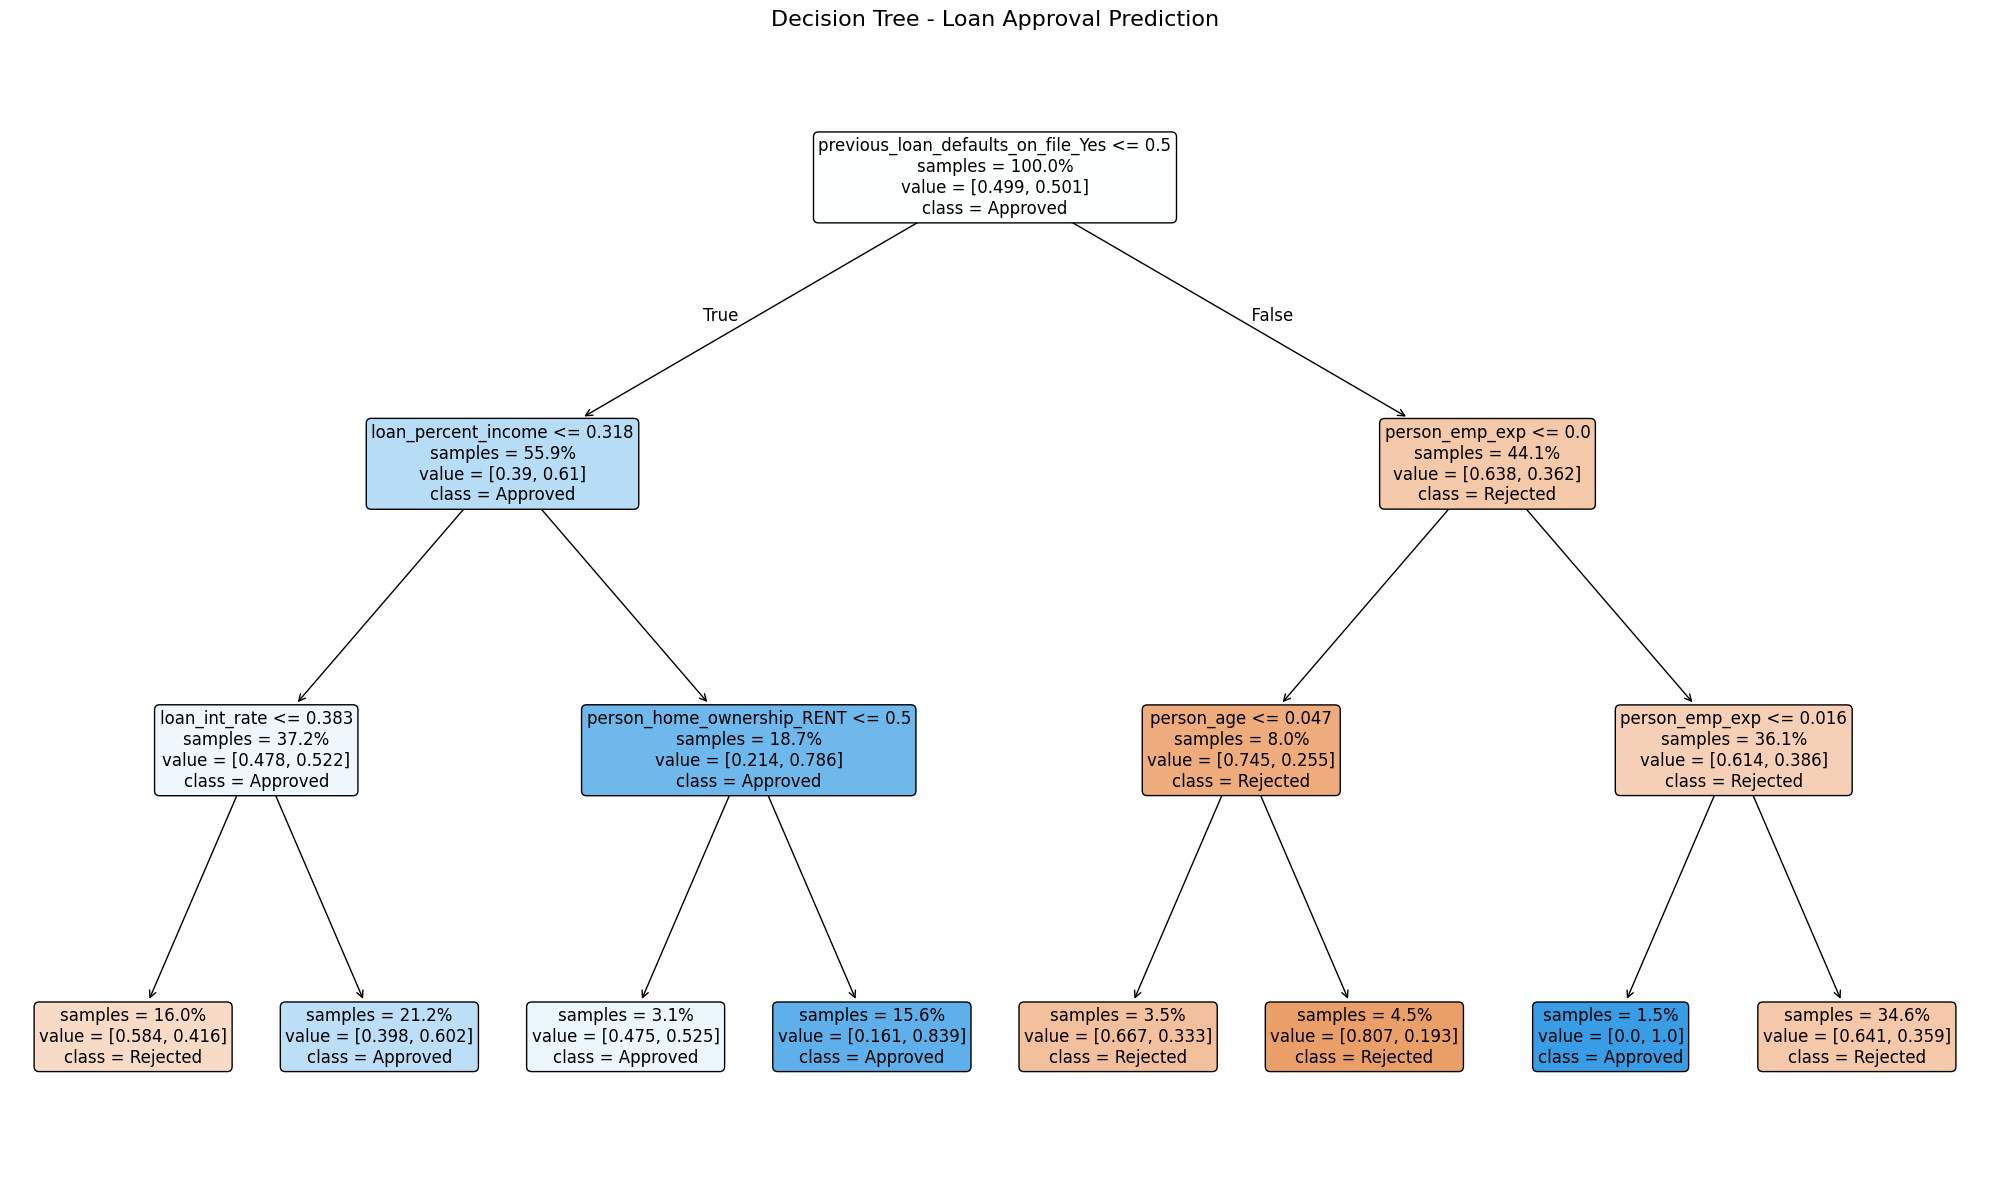

In [81]:
# Train/test split on SMOTE
X_smote = df_balanced.drop(columns=['loan_status'])
y_smote = df_balanced['loan_status']
X_smote_train, X_smote_test, y_smote_train, y_smote_test = train_test_split(X_smote, y_smote, test_size=0.2, random_state=42)



# Decision Tree
smote_dt_model = DecisionTreeClassifier(max_depth=3,random_state=42)
smote_dt_model.fit(X_smote_train, y_smote_train)

# Visualize the Decision Tree

# Visualize the Decision Tree
plt.figure(figsize=(20, 12))  
plot_tree(smote_dt_model,
          filled=True,
          rounded=True,
          feature_names=X_train.columns,
          class_names=['Rejected', 'Approved'],
          fontsize=12,
          impurity=False,       
          proportion=True)      
plt.title("Decision Tree - Loan Approval Prediction", fontsize=16)
plt.tight_layout()
plt.show()

dt_smote_cv_scores = cross_val_score(smote_dt_model, X_smote_train, y_smote_train, cv=5, scoring='accuracy')




--- Base Model Evaluation ---

Decision Tree:
              precision    recall  f1-score   support

    Rejected       0.82      0.95      0.88     10471
    Approved       0.62      0.29      0.39      2992

    accuracy                           0.80     13463
   macro avg       0.72      0.62      0.64     13463
weighted avg       0.78      0.80      0.77     13463



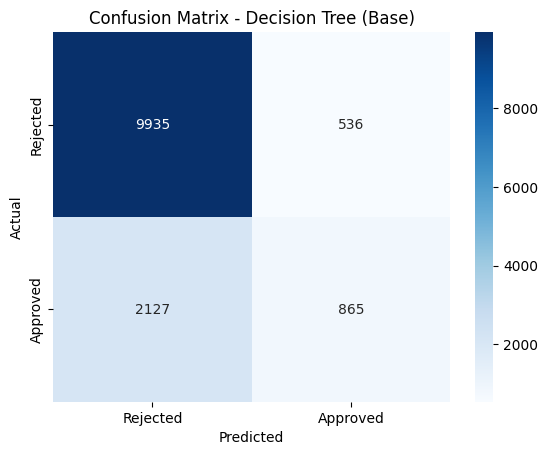

In [82]:
# --- Model Validation ---

# Evaluate base models on the test set
print("\n--- Base Model Evaluation ---")

# Decision Tree
dt_predictions = dt_model.predict(X_test)
print("\nDecision Tree:")
print(classification_report(y_test, dt_predictions, target_names=['Rejected', 'Approved']))
cm_dt = confusion_matrix(y_test, dt_predictions)
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Rejected', 'Approved'],
            yticklabels=['Rejected', 'Approved'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Decision Tree (Base)')
plt.show()


--- SMOTE DT Model Evaluation ---

Decision Tree:
              precision    recall  f1-score   support

    Rejected       0.63      0.75      0.69      7028
    Approved       0.69      0.56      0.62      6933

    accuracy                           0.66     13961
   macro avg       0.66      0.66      0.65     13961
weighted avg       0.66      0.66      0.65     13961



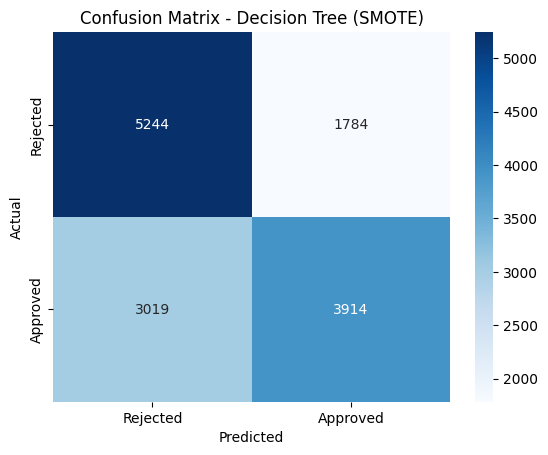

In [83]:
# SMOTE Decision Tree Evaluation
print("\n--- SMOTE DT Model Evaluation ---")

# Decision Tree
smote_dt_predictions = smote_dt_model.predict(X_smote_test)
print("\nDecision Tree:")
print(classification_report(y_smote_test, smote_dt_predictions, target_names=['Rejected', 'Approved']))

smote_cm_dt = confusion_matrix(y_smote_test, smote_dt_predictions)
sns.heatmap(smote_cm_dt, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Rejected', 'Approved'],
            yticklabels=['Rejected', 'Approved'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Decision Tree (SMOTE)')
plt.show()

In [84]:
# Cross-validation for Logistic Regression
dt_cv_scores = cross_val_score(LogisticRegression(random_state=42, solver='liblinear'),
                                X_train, y_train, cv=5, scoring='accuracy')
print("\nLogistic Regression Cross-Validation Comparison:")
print(f"{'Dataset':<20}{'Mean CV Accuracy':<20}")
print(f"{'Original':<20}{dt_cv_scores.mean():<20.4f}")
print(f"{'SMOTE':<20}{dt_smote_cv_scores.mean():<20.4f}")



Logistic Regression Cross-Validation Comparison:
Dataset             Mean CV Accuracy    
Original            0.7832              
SMOTE               0.6652              


In [85]:
# Logistic Regression Hyperparameter Tuning
lr_param_grid = {
    'C': np.logspace(-4, 4, 10),
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}
lr_grid_search = GridSearchCV(LogisticRegression(random_state=42),
                               param_grid=lr_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
lr_grid_search.fit(X_train, y_train)

print("\nLogistic Regression Best Parameters:", lr_grid_search.best_params_)
lr_best_model = lr_grid_search.best_estimator_


Logistic Regression Best Parameters: {'C': 166.81005372000558, 'penalty': 'l2', 'solver': 'liblinear'}



Logistic Regression (Tuned):
              precision    recall  f1-score   support

           0       0.79      0.98      0.88     10471
           1       0.61      0.10      0.17      2992

    accuracy                           0.79     13463
   macro avg       0.70      0.54      0.52     13463
weighted avg       0.75      0.79      0.72     13463



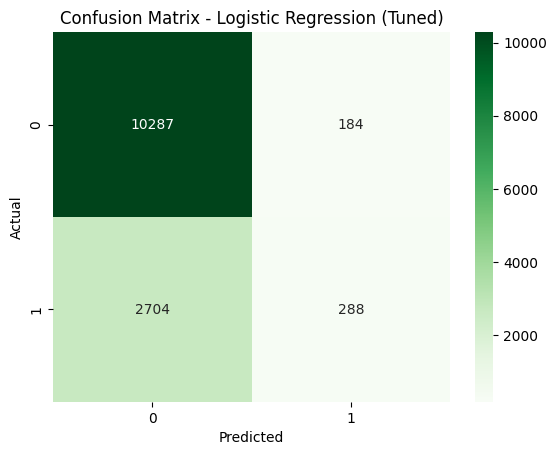

In [86]:
# Define string labels for display
target_names = ['0', '1'] 

# Generate predictions
lr_tuned_predictions = lr_best_model.predict(X_test)

# Classification report
print("\nLogistic Regression (Tuned):")
print(classification_report(y_test, lr_tuned_predictions, target_names=target_names))

# Confusion matrix
cm_lr_tuned = confusion_matrix(y_test, lr_tuned_predictions, labels=[0, 1])
sns.heatmap(cm_lr_tuned, annot=True, fmt='d', cmap='Greens',
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Logistic Regression (Tuned)')
plt.show()
